#Secotion 2 Project: Melbourne House Price Prediction

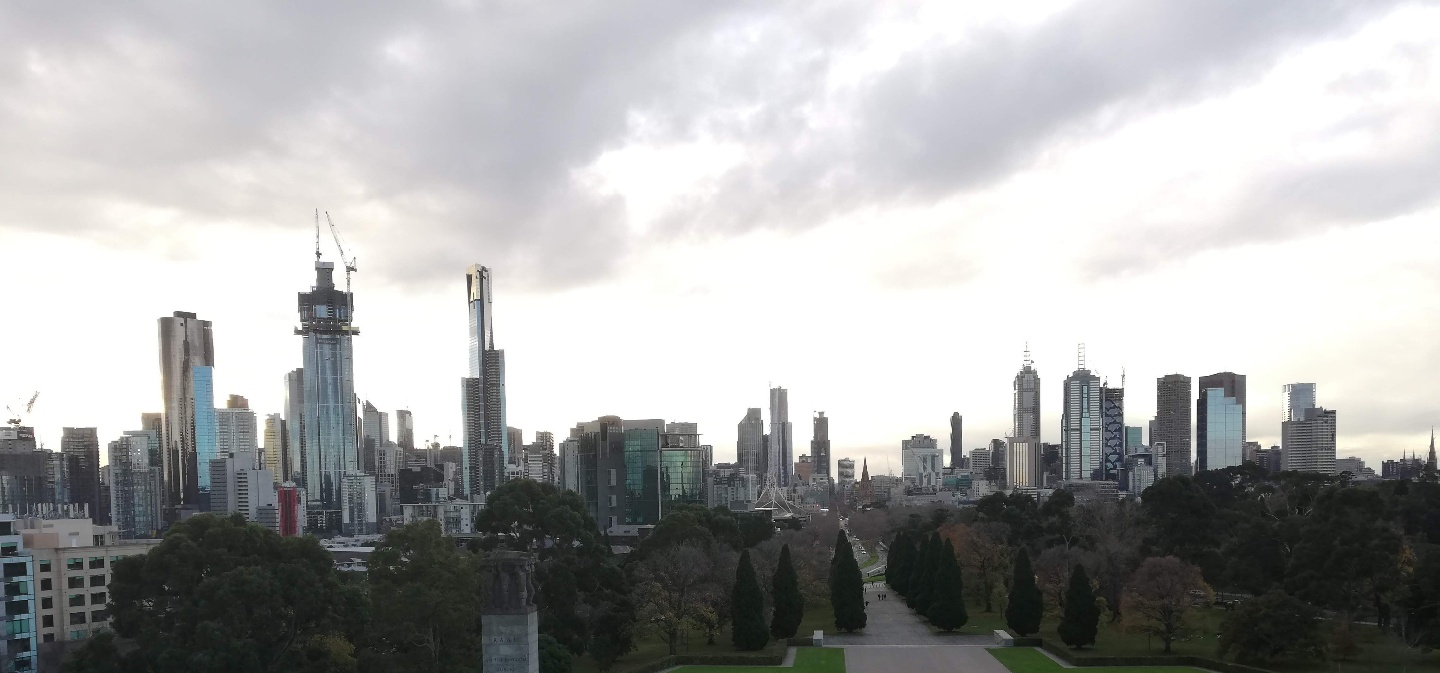



멜번은 호주의 경제, 문화, 교육의 중심지이자 아름다운 자연을 자랑하는 큰 도시입니다.

그러나 이주민의 증가와 외국인 부동산 투자가 급증하면서 멜번의 집값은 상승하면서도 예측하기 어려운 문제가 되었습니다.

그래서 이번 발표에서 집값을 예측하고, 집값에 영향을 미치는 요소와 중요도를 보여주는 모델을 소개하려고 합니다. 

##집값예측 가설

1. 각종 문화시설이 몰려있는 중심부에 가까울 수록 집값이 높을 것이다.

2. 화장실, 방 개수가 많은 큰 집일수록 집값이 높을 것이다. 


##데이터 셋 소개

###Target =>Price: Price in dollars (집 값)

###columns => 20개 feature

Distance: Distance from CBD (중심부로부터 거리)

Rooms: Number of rooms (방 개수)

Regionname: General Region (West, North West, North, North east …etc)

Type: h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse;
      (하우스, 유닛, 타운하우스)

Car: Number of carspots (주차가능한 차 개수)

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.


SellerG: Real Estate Agent

Date: Date sold

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Landsize: Land Size

BuildingArea: Building Size

CouncilArea: Governing council for the area


In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

In [42]:
!pip install category-encoders
!pip install shap
!pip install PDPbox

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from pandas_profiling import ProfileReport

In [44]:
df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/salesProject2/melb_data.csv')
df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,4.0,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,3.0,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


#1. EDA 및 FEATURE ENGINEERING

In [45]:
target = 'Price'

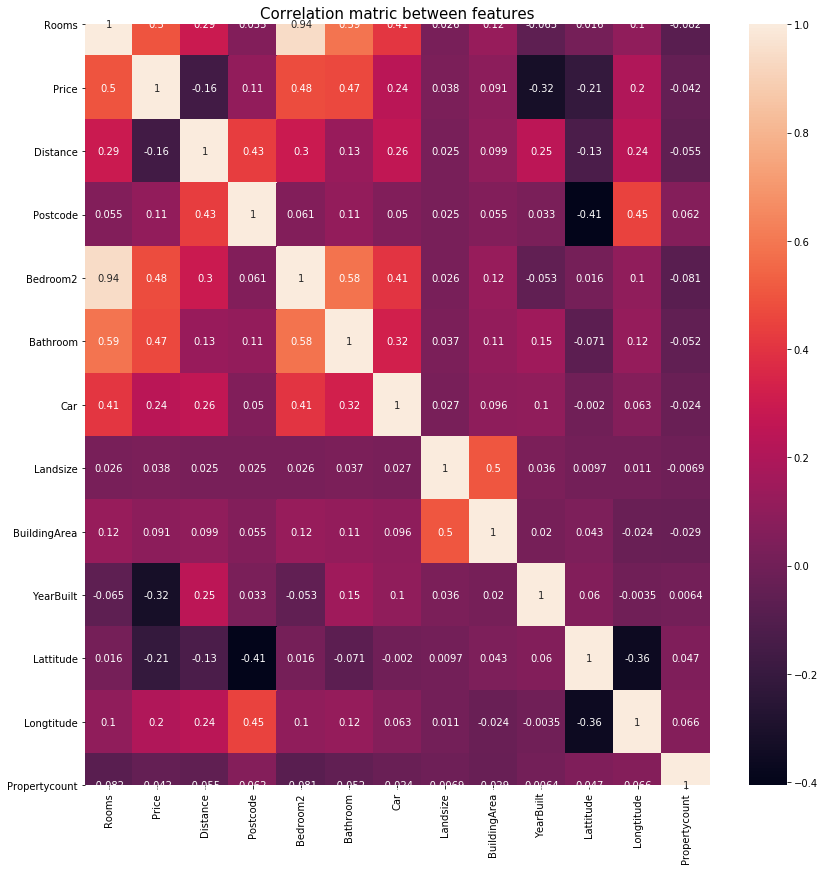

In [49]:
#변수간 상관관계 확인
#모든 변수간
%matplotlib inline
corr_df = df.corr()
colormap = plt.cm.RdBu

plt.figure(figsize=(14,14))
plt.title('Correlation matric between features', y=1, size = 15)
sns.heatmap(corr_df, annot= True)


In [ ]:
Price = pd.DataFrame(corr_df['Price'].sort_values(ascending = False))
Price
#rooms와 bedroom2, bathroom과 연관이 약간 있음. 

,Price
Price,1.000000
Rooms,0.496634
Bedroom2,0.475951
Bathroom,0.467038
Car,0.238979
Longtitude,0.203656
Postcode,0.107867
BuildingArea,0.090981
Landsize,0.037507
Propertycount,-0.042153


In [ ]:
#결측값 처리

#결측치 확인 =>Car, BuildingArea, YearBuilt, CouncilArea 총 4개의 피쳐에서 결측값 발생 (결측치 처리 아래에서)
df.isnull().sum()

data = df.copy()
Total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing= pd.concat([Total, percent], axis =1, keys = ['Total', 'Percent'])
missing

#전체 데이터 13580인데 중 1/3 이상이 결측값 & 상관관계가 매우 낮은 BuildingArea(6450)랑 YearBuilt(5375)는 데이터 칼럼 삭제 
#CouncilArea랑 Car도 큰 상관관계가 있는 것은 아니지만 결측치가 아주 많은게 아니기에 아래에서 결측치 처리

data = data.drop(columns = ['BuildingArea', 'YearBuilt'], axis = 1)

#남은 두 개의 데이터 CouncilArea와 Car 결측치 처리

#numeric data => mean으로 대체하기남은 두 개의 데이터 CouncilArea와 Car 결측치 처리

#numeric data => mean으로 대체하기
numeric_missed = ['Car']
for feature in numeric_missed:
  data[feature].fillna(df[feature].mean(),inplace = True)

#categorical data => 최빈값으로 대체하기
categorical_missed = ['CouncilArea']
for feature in categorical_missed:
  data[feature].fillna(data[feature].mode()[0], inplace = True)

data.isnull().sum().max() #=>결측치 채우기 끝

0

###결측치처리

Car, BuildingArea, YearBuilt, CouncilArea 총 4개의 피쳐에서 결측값 발생
1. 전체 데이터 13580인데 중 1/3 이상이 결측값 & 상관관계가 매우 낮은 BuildingArea(6450)랑 YearBuilt(5375)는 데이터 칼럼 삭제 
2. CouncilArea랑 Car도 큰 상관관계가 있는 것은 아니지만 결측치가 아주 많지 않으므로, 각 최빈값과 평균값으로 결측치 대체

=>데이터 결측치 : 0

In [ ]:
#데이터 타입 변화(postcode)
data['Postcode'] = data['Postcode'].astype(object)

# 2. 타겟 분할/ 인코딩/ 데이터 정규화

In [ ]:
#데이터셋 나누기(hould-out)
target = 'Price'
features = data.columns.drop(target)

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.25)
train, val = train_test_split(train, test_size = 0.25)
X_train = train[features]
X_test = test[features]
X_val = val[features]
y_train = train[target]
y_test = test[target]
y_val = val[target]

In [ ]:
#인코딩(Onehot: cardinality issue, Target보다 Ordinal 사용 모델 성능 우수)
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [ ]:
#데이터 정규화
from sklearn.preprocessing import MinMaxScaler

minMaxNorm = MinMaxScaler()
minMaxNorm.fit_transform(X_train_encoded)
minMaxNorm.fit_transform(X_val_encoded)
minMaxNorm.fit_transform(X_test_encoded)

In [ ]:
#기준 모델 정확도
predict = y_train.mean()
pred_train = [predict] * len(y_train)
print('기준모델 MAE:',mean_absolute_error(y_train, pred_train))


기준모델 MAE: 461105.5316236241


#3. 모델선택

*  XGBOOST
*  RANDOM FOREST
*  RIDGE



> 평가지표: 교차검증 k = 5개 MAE










#모델1(XGBOOST) 

In [ ]:
#인코딩 및 모델 학습
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators = 1000,
    learning_rate =0.1,
    n_jobs = -1
)

eval_set = [(X_train_encoded, y_train), (X_val_encoded,y_val)]

xgb.fit(X_train_encoded, y_train, eval_set = eval_set, early_stopping_rounds = 50)

In [ ]:
#검증 테스트(xgboost)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

predict_val_ordinal = xgb.predict(X_val_encoded)
print('검증 MAE:', mean_absolute_error(y_val, predict_val_ordinal) )

#CV
k = 5
scores_xgbo = cross_val_score(xgb, X_train_encoded, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores_xgbo)
print(-scores_xgbo.mean())

검증 MAE: 180309.64890373478
[06:04:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE for 5 folds: [220243.7033244  174846.92380767 176803.45889234 176456.25353021
 174412.00199533]
184552.4683099919


#모델2 (RANDOM FOREST)

In [ ]:
#Ordinal 인코더 사용
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
pipe2 = make_pipeline(
    OrdinalEncoder(),  
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)

k = 5

scores2 = cross_val_score(pipe2, X_train_encoded, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores2)
print(-scores2.mean())

MAE for 5 folds: [193335.98652073 186366.7956818  178541.29337108 185377.52898493
 182509.32196068]
185226.18530384597


#모델3 (RIDGE)

In [ ]:
from sklearn.linear_model import Ridge
pipe4 = make_pipeline(
    OrdinalEncoder(), 
    Ridge(alpha = 1.0)
)

k = 5

scores = cross_val_score(pipe4, X_train_encoded, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)
print(-scores.mean())

MAE for 5 folds: [294532.34372047 300938.44569734 288679.81346319 288778.43647713
 293695.19405822]
293324.8466832697


XGBoost,RandomForest,Ridge를 Ordinal 인코더를 사용해 각각 예측한 결과, 



> 5개 검증세트로 교차검증한 MAE 평균


*   XGBOOST : 184552.4683099919
*   RANDOM FOREST : 185226.18530384597
*   RIDGE : 293324.8466832697


결론적으로 XGBOOST가 가장 오류가 적은 알고리즘이다. 따라서 XGBOOST를 선택하고, 
예측력을 높이기 위해서 하이퍼 파라미터를 사용해보자.

#4. 하이퍼 파라미터 설정
하이퍼파라미터를 설정하는 것은 가장 최대의 정확도와 최소의 오류를 발생시키는 매개변수세트를 찾는 과정이다. 
즉, 최상의 성능을 가져오는 매개변수를 찾는 과정이다. 


> GrideSearch 사용



In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from scipy.stats import randint

#모델 설정
model = XGBRegressor()

#파라미터설정
params = {
    'n_estimators': [110, 120, 130, 140], 
    'learning_rate': [ 0.05, 0.075, 0.1],
    'max_depth': [ 7, 9],
    'reg_lambda': [0.3, 0.5]
}

xgb_reg = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1)

xgb_reg = xgb_reg.fit(X_train_encoded, y_train)

#최적 모델의 성능
xgbr_model_score = xgb_reg.best_score_

xgbr_model_pred = xgb_reg.predict(X_val_encoded)

mae = mean_absolute_error(y_val, xgbr_model_pred)

print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)

#하이퍼파라미터 튜닝된 베스트 모델로 검정세트 MAE확인
print("mean_absolute_error :", mae)

[06:11:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 0.784
Best parameters set: {'learning_rate': 0.075, 'max_depth': 7, 'n_estimators': 140, 'reg_lambda': 0.5}
mean_absolute_error : 174975.41058107576


In [ ]:
#best param으로 학습
regressor = XGBRegressor(learning_rate= 0.075, max_dept= 7, n_estimators= 140, reg_lambda= 0.5).fit(X_train_encoded, y_train)

[06:11:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#최종모델 test 점수 확인

y_predict_test = regressor.predict(X_test_encoded)
print('최종 테스트세트 MAE:', mean_absolute_error(y_test, y_predict_test))

최종 테스트세트 MAE: 195773.66715758468


베이스라인 기준모델


> 기준모델 MAE: 461105.5316236241

새로 만든 모델 


> 최종 테스트세트 MAE: 195773.66715758468


기준모델에 비해 오류가 두 배 이상 향상되었다. 




#5. 최종모델 해석




> Permutation feature importance, PDP, SHAP을 통해서 집 값에 영향을 미치는 요인들을 분석하고자 한다. 



1.   Permutation feature importance를 feature 줄이기
2.   PDP 분석을 통해 각 피쳐가 전체 가격에 어떠한 영향(+/-)을 미치는지 살펴보기
3.   SHAP 분석을 통해 각 피쳐가 얼마만큼의 중요도를 가졌는지 살펴보기



In [ ]:
!pip install eli5

In [ ]:
#permutaion feature
print('특성 삭제 전:', 'X_train.shape =', X_train.shape,'X_val.shape =', X_val.shape)
regressor_val_predict = regressor.predict(X_val_encoded)
print('특성 삭제 전 검증세트 오류 MAE:', mean_absolute_error(y_val, regressor_val_predict))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    regressor, # model
    scoring='neg_mean_absolute_error', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_encoded, y_val);

feature_names = X_val_encoded.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending = False)

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

특성 삭제 전: X_train.shape = (7638, 18) X_val.shape = (2547, 18)
특성 삭제 전 검증세트 오류 MAE: 193616.66655624265


Weight,Feature
155603.9234 ± 6558.4261,Distance
86672.2795 ± 5421.1089,Type
57602.0189 ± 5363.9087,Rooms
55855.2772 ± 3925.2507,Landsize
49531.0814 ± 3646.4443,Lattitude
45027.6964 ± 3407.2359,Bathroom
38123.9601 ± 2995.0504,Regionname
23363.1403 ± 2146.7647,Longtitude
10761.0803 ± 848.4494,Suburb
8392.1656 ± 316.9696,Postcode


In [58]:
#중요도가 20000보다 작은 피쳐 삭제

minimum_importance = 20000
mask = permuter.feature_importances_ > minimum_importance
features = X_train_encoded.columns[mask]
X_train_selected = X_train_encoded[features]
X_val_selected = X_val_encoded[features]
X_test_selected = X_test_encoded[features]

print('특성 삭제 후:','X_train.shape =', X_train_selected.shape,'X_val.shape =', X_val_selected.shape)

#특성 삭제 후 permuter다시 정의

regressor.fit(X_train_selected, y_train)
regressor_val_predict_little = regressor.predict(X_val_selected)
print('검증 정확도:', mean_absolute_error(y_val, regressor_val_predict_little))


특성 삭제 후: X_train.shape = (7638, 8) X_val.shape = (2547, 8)
[07:51:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
검증 정확도: 195530.25422065175


In [59]:
#검증정확도에 큰 차이가 없으므로, 8개의 행만 가지고 계속 진행한다. 
X_train_selected.columns

Index(['Rooms', 'Type', 'Distance', 'Bathroom', 'Landsize', 'Lattitude',
       'Longtitude', 'Regionname'],
      dtype='object')

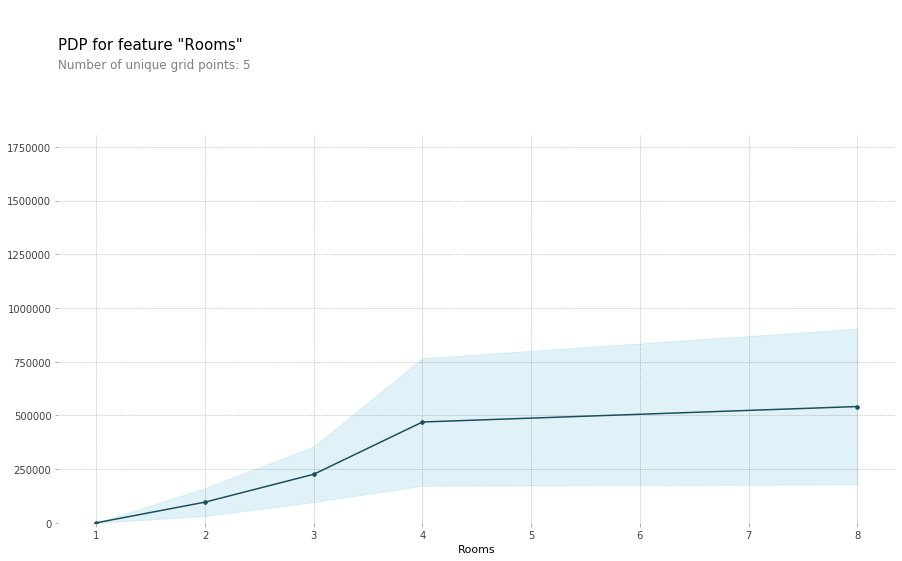

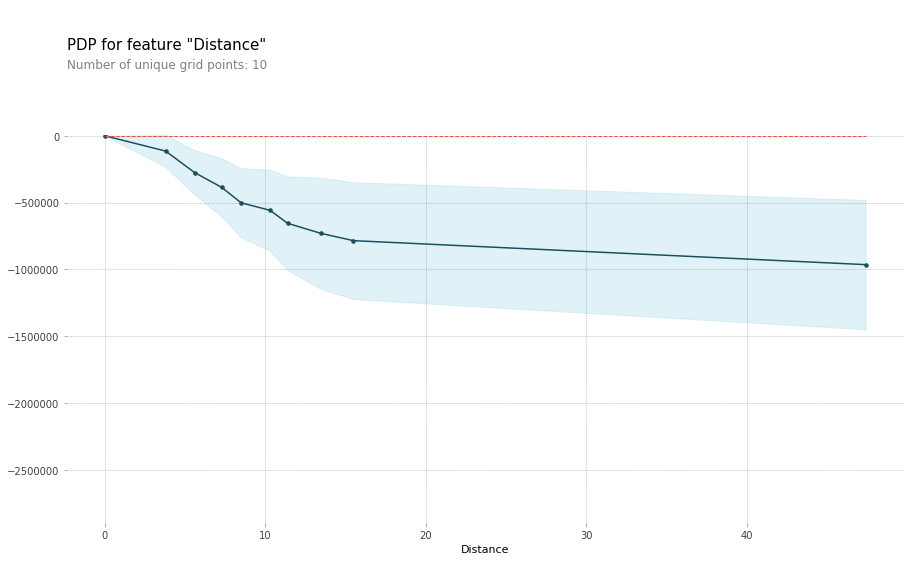

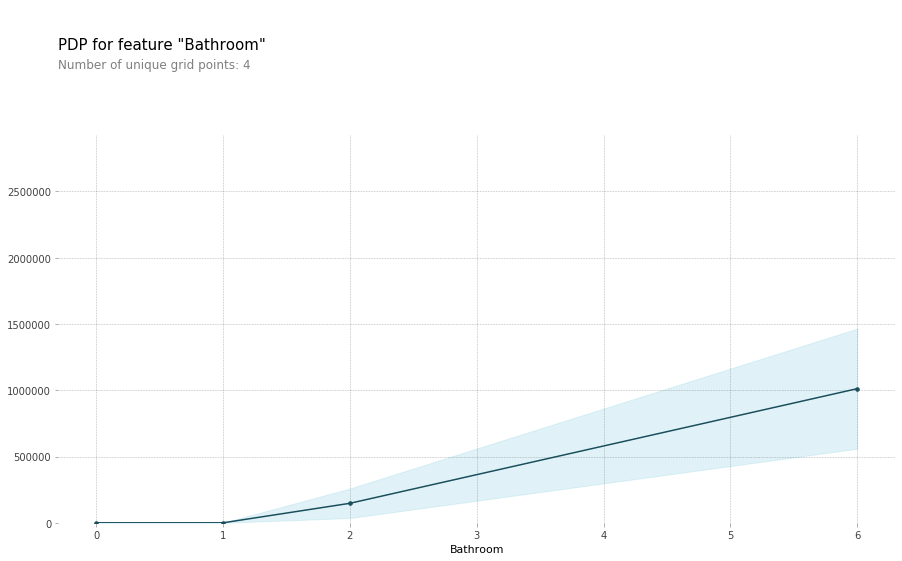

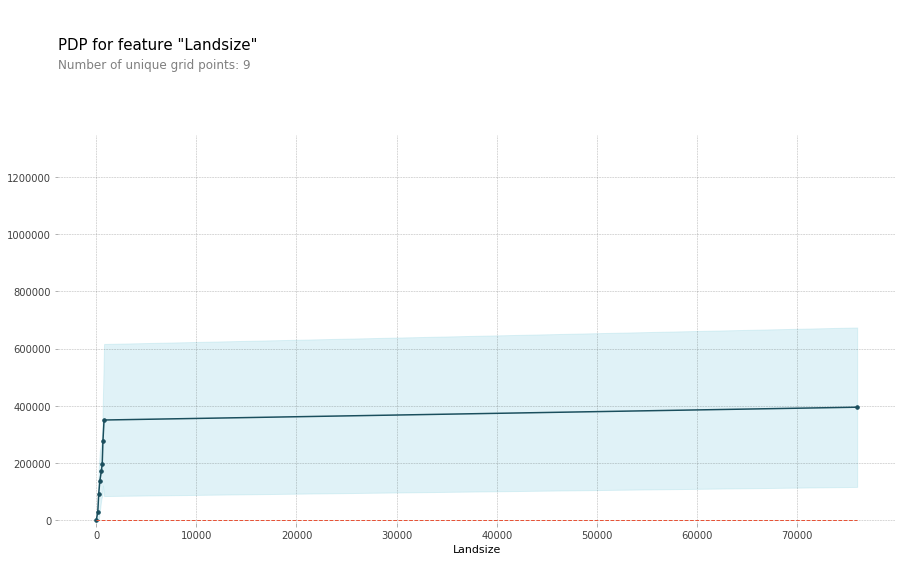

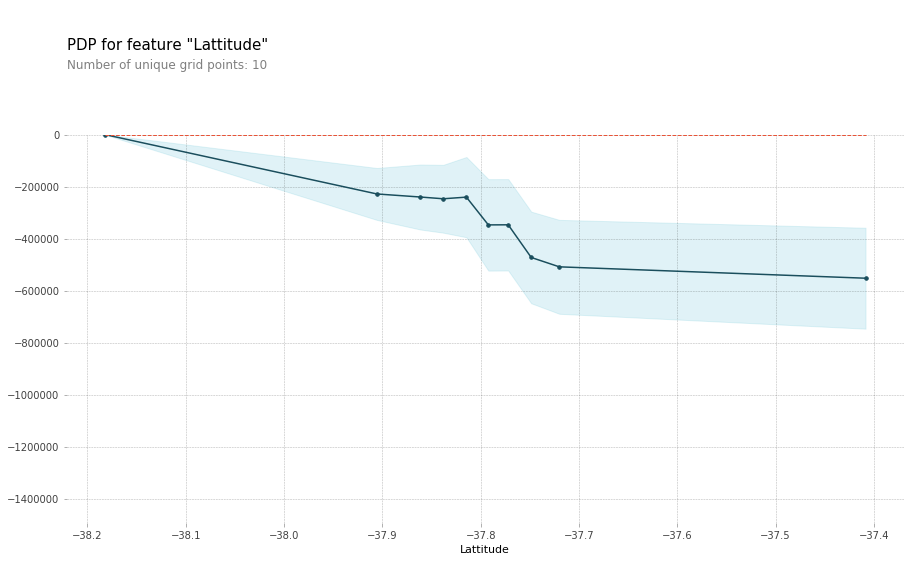

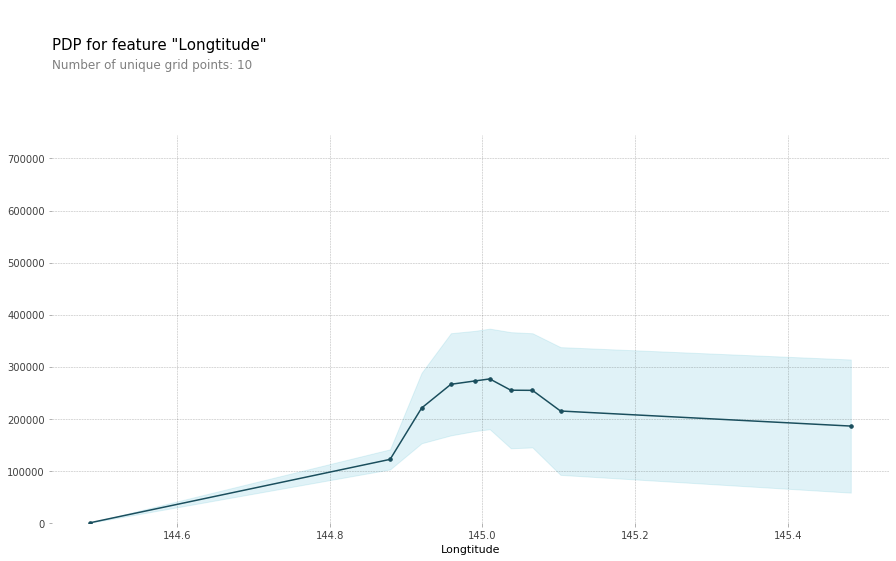

In [60]:
#선택된 피쳐가 집값에 어떤 영향(+/-)을 미치는지 알아보기 위해 PDP분석을 해보자

from pdpbox.pdp import pdp_isolate,pdp_plot

#numeric데이터 

for feature in X_train_encoded[['Rooms', 'Distance', 'Bathroom', 'Landsize', 'Lattitude',
       'Longtitude']]:
  
  isolated = pdp_isolate(
      model = regressor,
      dataset = X_train_encoded,
      model_features = X_train_selected.columns,
      feature = feature
  )

  pdp_plot(isolated, feature_name = feature)


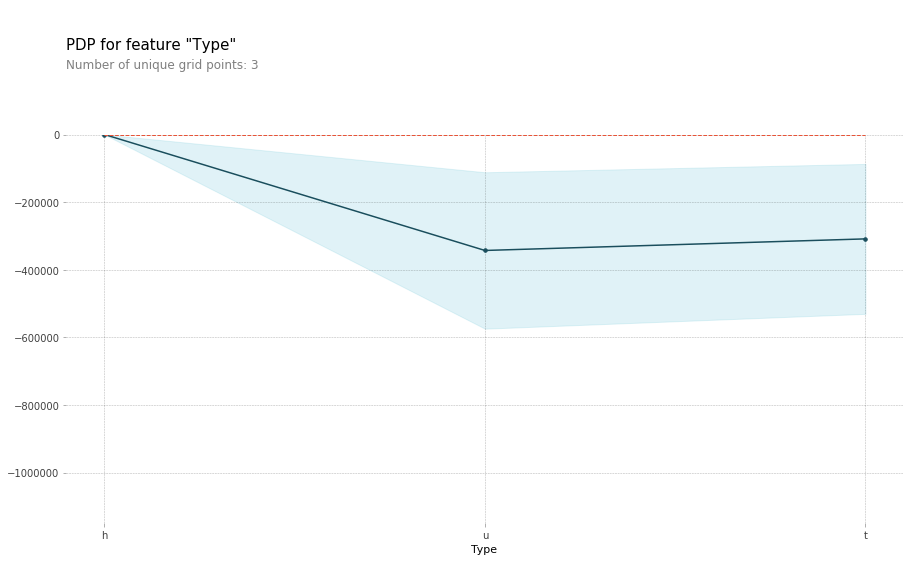

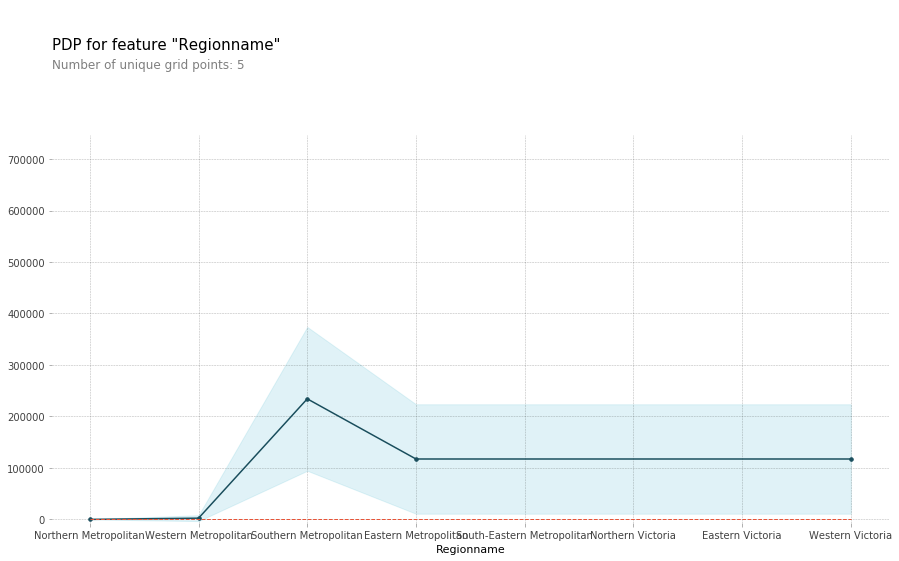

In [53]:
#category 데이터
for feature in X_train_encoded[['Type', 'Regionname']]:
  for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series

    isolated = pdp_isolate(
    model = regressor,
    dataset = X_train_encoded,
    model_features = X_train_selected.columns,
    feature = feature
  )
     
        
    feature_mapping = feature_mapping[feature_mapping.index.dropna()]
    category_names = feature_mapping.index.tolist()
    category_codes = feature_mapping.values.tolist()

  pdp_plot(isolated, feature)
  plt.xticks(category_codes, category_names);

[07:51:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


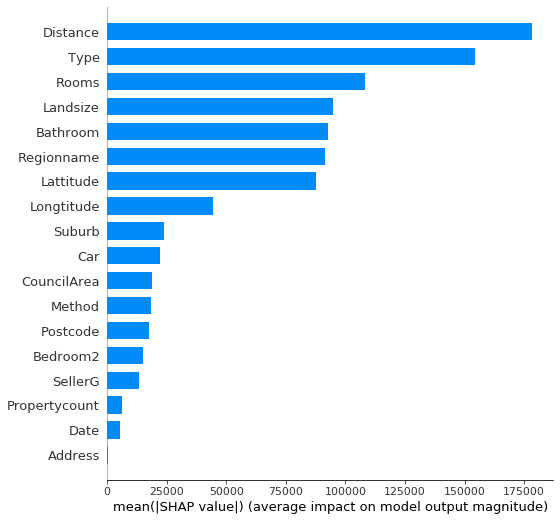

In [61]:
#집값에 가장 영향을 많이 미치는 요소 

import shap
#permuter  다시정의
regressor.fit(X_train_encoded, y_train)

row = X_test_encoded.iloc[[1]]
explainer= shap.TreeExplainer(regressor)

shap.initjs()
shap_values = explainer.shap_values(X_train_encoded.iloc[:200])
shap.summary_plot(shap_values, X_train_encoded.iloc[:300], plot_type="bar")

In [62]:
#테스트 데이터 5개에 어떠한 특성이 영향을 미쳤는가 
rowtoshow = 5
row = X_test_encoded.iloc[rowtoshow]
row_array = row.values.reshape(1,-1)


explainer= shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

#6. 결론

멜번의 집 값은 멜번시티에서 거리가 멀수록, 집이 하우스 타입일수록, 방의 개수가 많을수록 비싸다. 이는 위의 가설과 일치한다고 할 수 있다. 